# **Understand and Inspect the Dataset**

### **Step 1: Deep Dive into Evaluation Metric**

The competition uses the **sample-weighted zero-mean R² score** for `responder_6`

#### **Key Insights to Explore**
1. **Impact of Weighting (`w_i`)**:
   - Rows with higher weights (`w_i`) influence the R² score more. Misclassifications in high-weight regions penalize the model disproportionately.
   - Analyze the distribution of weights in the dataset and their correlation with `responder_6`.

2. **Zero-Mean Adjustment**:
   - Predictions (`\hat{y}`) need to align with the zero-mean transformation of `y`.
   - Failing to account for this adjustment could skew residual errors and reduce the score.

3. **Numerator and Denominator Properties**:
   - Numerator (\(\sum_i w_i (y_i - \hat{y}_i)^2\)): Represents weighted mean squared error (MSE). The lower this value, the better.
   - Denominator (\(\sum_i w_i y_i^2\)): Represents the weighted variance of the target variable, serving as a normalization factor.

#### **Technical Plan**
1. **Extract and Analyze Weight Distribution**:
   - Load a sample of `train.parquet`.
   - Compute statistical properties (mean, std, min, max) and visualize the weight distribution.
   - Explore if high weights align with specific ranges of `responder_6` or `date_id`.

2. **Understand Zero-Mean Impact**:
   - Compute the mean of `responder_6` per `date_id` and evaluate how the mean shifts temporally.
   - Analyze whether zero-mean adjustments are consistent over time or require time-aware preprocessing.

3. **Verify Sensitivity to Predictions**:
   - Simulate small errors in `\hat{y}` for high-weight rows and calculate their impact on R².
   - This can guide optimization strategies, e.g., assigning higher importance to high-weight regions during training.


### Visual analysis

date_id              0
time_id              0
symbol_id            0
weight               0
feature_00     1944210
                ...   
responder_4          0
responder_5          0
responder_6          0
responder_7          0
responder_8          0
Length: 92, dtype: int64


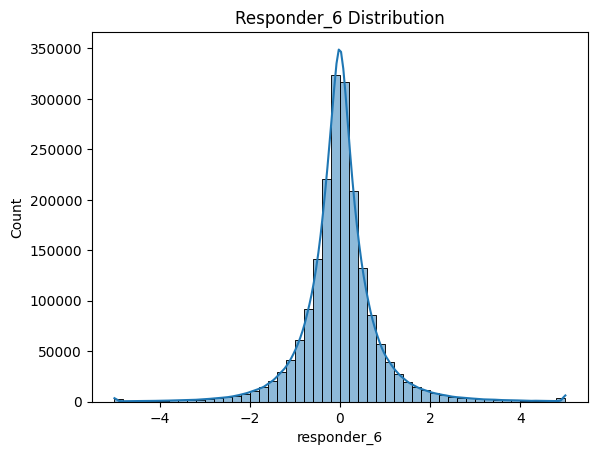

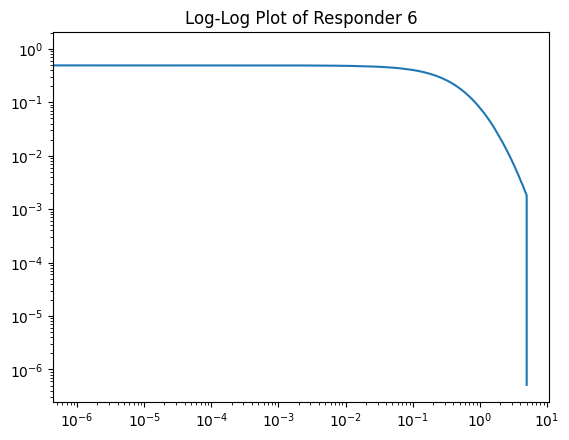

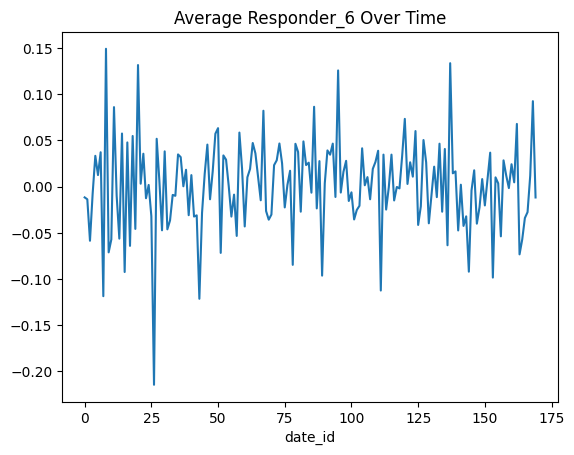

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
# df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition/data/raw/train/partition_id=0/part-0.parquet')
# df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition/data/processed/combined_train_data.parquet')
raw_data = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/JaneStreetKaggleCompetition/data/processed/combined_train_data.parquet')

# Check for missing values
print(raw_data.isnull().sum())

responder = raw_data['responder_6']
# plt.hist(responder, bins=100, density=True, alpha=0.6, color='g')
# plt.title('Responder 6 Distribution Log Scaled Y')
# plt.yscale('log')  # Log scale to inspect fat tails
# plt.show()

sns.histplot(responder, bins=50, kde=True)
plt.title("Responder_6 Distribution")
plt.show()

# Log-log plot for tail
sorted_responder = np.sort(responder)
plt.loglog(sorted_responder, np.arange(len(sorted_responder), 0, -1) / len(sorted_responder))
plt.title('Log-Log Plot of Responder 6')
plt.show()

# Trends over time
avg_responder = raw_data.groupby("date_id")["responder_6"].mean()
avg_responder.plot(title="Average Responder_6 Over Time")
plt.show()


### Weight Statistics

Let's compute the basic descriptive statistics for the weight column.


In [ ]:
# Compute and display weight statistics
weight_stats = raw_data['weight'].describe()
print("Weight Statistics:")
print(weight_stats)


Weight Statistics:
count    1.944210e+06
mean     1.973281e+00
std      9.679003e-01
min      4.405696e-01
25%      1.323803e+00
50%      1.763827e+00
75%      2.393846e+00
max      6.011999e+00
Name: weight, dtype: float64


### Visualizing Weight Distribution

We'll plot histograms and boxplots to visualize the distribution of weights.


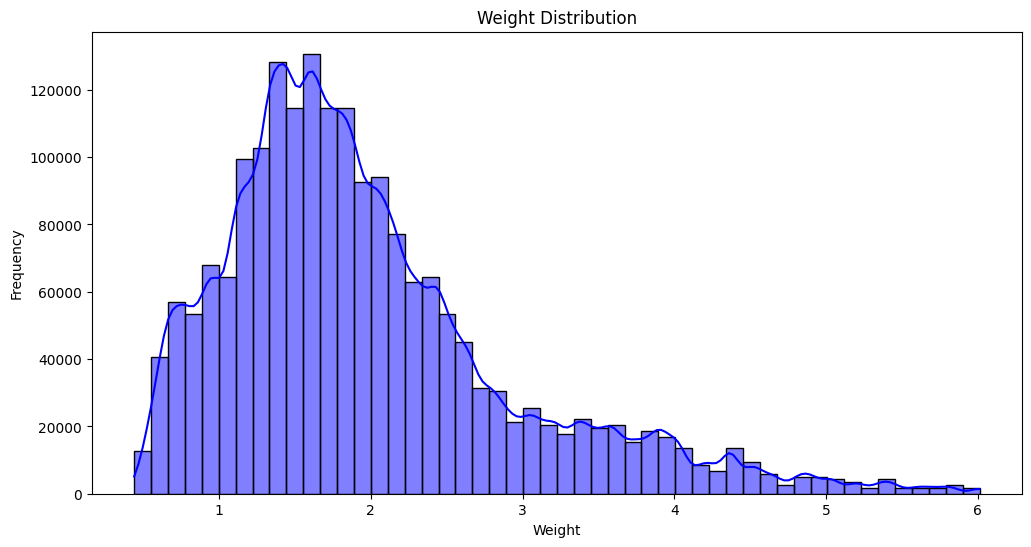

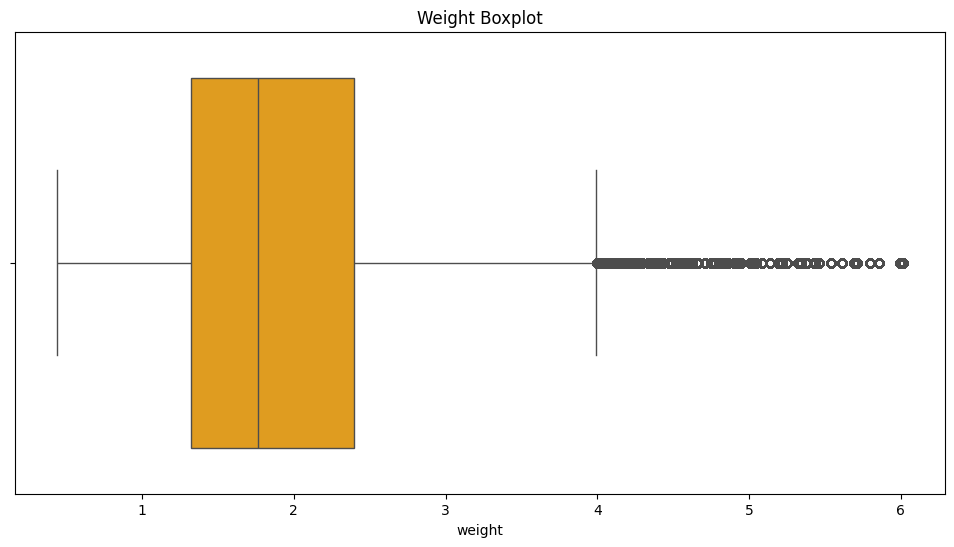

In [ ]:
# Visualize distribution
plt.figure(figsize=(12, 6))
sns.histplot(raw_data['weight'], bins=50, kde=True, color='blue')
plt.title("Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=raw_data['weight'], color='orange')
plt.title("Weight Boxplot")
plt.show()


##**Weight Distribution:**

The weight variable exhibits a right-skewed distribution with most values concentrated between 1 and 3.
A small number of outliers extend beyond 5, as evident from the boxplot.

### Correlation Between Weights and Responder_6

Next, we'll compute the correlation between `weight` and `responder_6`, and visualize this relationship using a scatter plot.


Correlation between weight and responder_6: 0.0002


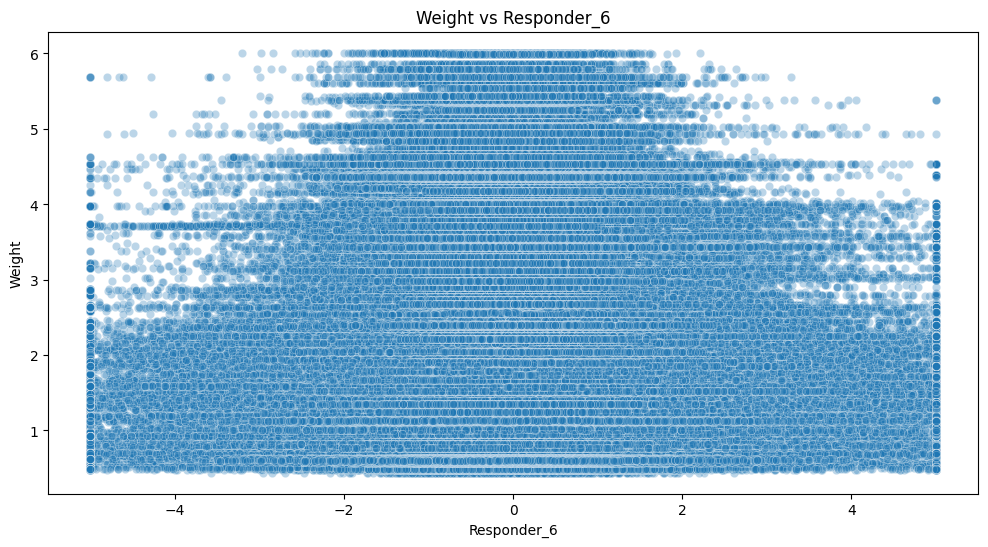

In [ ]:
# Correlation analysis
correlation = raw_data[['weight', 'responder_6']].corr().iloc[0, 1]
print(f"Correlation between weight and responder_6: {correlation:.4f}")

# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x=raw_data['responder_6'], y=raw_data['weight'], alpha=0.3)
plt.title("Weight vs Responder_6")
plt.xlabel("Responder_6")
plt.ylabel("Weight")
plt.show()


##**Weight vs. Responder_6 Correlation:**

The correlation between weight and responder_6 is extremely weak (
𝑟
=
0.0002
r=0.0002), suggesting negligible linear dependence between these two variables.
The scatter plot reveals no discernible pattern or trend, further supporting the lack of linear correlation

In [ ]:
from scipy.stats import kurtosis

# Kurtosis for responder_6
kurt = kurtosis(responder, fisher=True)
print(f'Kurtosis of Responder 6: {kurt}')

# Hill estimator
def hill_estimator(data, threshold_percentile=95):
    threshold = np.percentile(data, threshold_percentile)
    tail_data = data[data > threshold]
    alpha = len(tail_data) / np.sum(np.log(tail_data / threshold))
    return alpha

alpha = hill_estimator(responder)
print(f'Tail index (alpha): {alpha}')


Kurtosis of Responder 6: 6.820833450753845
Tail index (alpha): 2.2578235814034424


##Kurtosis:
**Interpretation**: Kurtosis indicates the "tailedness" of the data distribution. A kurtosis value significantly greater than 3 (which is the kurtosis of a normal distribution) suggests a distribution with heavier tails and a sharper peak. A value of 6.8208 implies that your data has more outliers or extreme values compared to a normal distribution.


---


##Tail Index (alpha):
**Interpretation**: The tail index, often denoted as alpha, is used in the
context of heavy-tailed distributions. It characterizes the rate at which the tail of the distribution tapers off. An alpha value between 2 and 3 indicates that your data has heavy tails, but the variance is finite. This means the data includes extreme values, though not frequently enough to cause infinite variance.

**Interpreting Statistical Indicators**

Kurtosis=6.82 (greater than 3): This indicates the presence of **leptokurtic behavior**, meaning the distribution has heavier tails and a sharper peak than a normal distribution. This aligns with the visual evidence of fat tails.

α=2.26: A tail index between 2 and 3 suggests that the distribution has finite variance (but potentially infinite higher moments, such as skewness). This further confirms the fat-tailed nature of the data.

Tail index estimation is critical for understanding the risk of extreme values in financial markets.


In [ ]:
# Calculate statistics
print("Mean:", raw_data['responder_6'].mean())
print("Variance:", raw_data['responder_6'].var())
print("Skewness:", raw_data['responder_6'].skew())
print("Kurtosis:", kurtosis(raw_data['responder_6']))

Mean: 0.0014876343
Variance: 0.7563174366950989
Skewness: 0.29999408
Kurtosis: 6.820833450753845


In [ ]:
raw_data.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000
